In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import statsmodels

In [2]:
# input files/dir
ANNOTATED_MUTATIONS = "../data/annotated_snv_mv_indels_by_cancer_subtype"
GENOME_WIDE_MUTATIONS = "../data/genome_wide_mutation_data.tsv"
DRIVER_GENES = "../data/driver_genes"
CLINICAL_DATA = "../data/datasets/PCAWG/clinical_data/pcawg_donor_clinical_data.csv"
WHITELISTED_SAMPLES = "../data/datasets/PCAWG/supplementary Tables/Supplementary Table 1.csv"
SURVIVAL_DATA = "../data/datasets/TCGA_data/TCGA_survival_outcome.csv"
CANCER_PATHWAYS = "../metadata/gene_pathways.csv"
CANCER_GENE_TYPES = "../metadata/cancer_genes.tsv"

# output files/ directories
OS_ANALYSIS = "../results/OS_pancancer"
OS_CADD_ANALYSIS = "../results/OS_pancancer_CADD"
OS_ANALYSIS_PATHWAY = "../results/OS_pancancer_pathway"

if not os.path.exists(OS_ANALYSIS):
    os.makedirs(OS_ANALYSIS)
if not os.path.exists(OS_CADD_ANALYSIS):
    os.makedirs(OS_CADD_ANALYSIS)
if not os.path.exists(OS_ANALYSIS_PATHWAY):
    os.makedirs(OS_ANALYSIS_PATHWAY)
    
CANCER_TYPES = os.listdir(DRIVER_GENES) # cancer types with driver genes
CANCER_TYPES = [cancer_type for cancer_type in CANCER_TYPES if cancer_type.endswith(".tsv")]
CANCER_TYPES = [cancer_type.replace(".tsv", "") for cancer_type in CANCER_TYPES]
print(len(CANCER_TYPES), CANCER_TYPES)

31 ['CNS-Oligo', 'Kidney-ChRCC', 'Prost-AdenoCA', 'Kidney-RCC', 'Stomach-AdenoCA', 'CNS-Medullo', 'Thy-AdenoCA', 'Myeloid-MPN', 'Bone-Leiomyo', 'Lymph-BNHL', 'Myeloid-AML', 'Lung-AdenoCA', 'CNS-GBM', 'Head-SCC', 'Breast-AdenoCa', 'Ovary-AdenoCA', 'CNS-PiloAstro', 'Cervix-SCC', 'Liver-HCC', 'Bone-Osteosarc', 'Biliary-AdenoCA', 'Skin-Melanoma', 'Lung-SCC', 'Lymph-CLL', 'Panc-Endocrine', 'Bladder-TCC', 'Panc-AdenoCA', 'ColoRect-AdenoCA', 'Breast-LobularCa', 'Eso-AdenoCa', 'Uterus-AdenoCA']


In [3]:
whitelisted_data = pd.read_csv(WHITELISTED_SAMPLES, sep=",", header=0)
whitelisted_samples = whitelisted_data["tumour_specimen_aliquot_id"].unique().tolist()
print(f"Number of unique samples in the whitelist: {len(whitelisted_samples)}")

Number of unique samples in the whitelist: 2583


In [4]:
# get all mutations in driver genes
tumor_mut_df = pd.DataFrame()
for cancer_type in CANCER_TYPES:
	print(cancer_type)
	tumor_mut_cancer_df = pd.read_csv(f"{ANNOTATED_MUTATIONS}/{cancer_type}.tsv", sep="\t")
	driver_genes = pd.read_csv(os.path.join(DRIVER_GENES, cancer_type + ".tsv"), sep="\t")
	driver_genes_list = driver_genes["gene"].tolist()
	tumor_mut_cancer_df = tumor_mut_cancer_df[tumor_mut_cancer_df["gene"].isin(driver_genes_list)]
	tumor_mut_cancer_df = pd.merge(tumor_mut_cancer_df, driver_genes[["gene", "gene_length"]], on="gene", how="left")

	# get genome-wide mutation data
	genome_wide_mutations = pd.read_csv(GENOME_WIDE_MUTATIONS, sep="\t")
	tumor_mut_cancer_df = pd.merge(tumor_mut_cancer_df, genome_wide_mutations, on=["Tumor_Sample_Barcode"], how="left")
	tumor_mut_cancer_df["cancer_type"] = cancer_type
	tumor_mut_df = pd.concat([tumor_mut_df, tumor_mut_cancer_df], ignore_index=True)
tumor_mut_df.head()

CNS-Oligo
Kidney-ChRCC
Prost-AdenoCA
Kidney-RCC
Stomach-AdenoCA
CNS-Medullo
Thy-AdenoCA
Myeloid-MPN
Bone-Leiomyo
Lymph-BNHL
Myeloid-AML
Lung-AdenoCA
CNS-GBM
Head-SCC
Breast-AdenoCa
Ovary-AdenoCA
CNS-PiloAstro
Cervix-SCC
Liver-HCC
Bone-Osteosarc
Biliary-AdenoCA
Skin-Melanoma
Lung-SCC
Lymph-CLL
Panc-Endocrine
Bladder-TCC
Panc-AdenoCA
ColoRect-AdenoCA
Breast-LobularCa
Eso-AdenoCa
Uterus-AdenoCA


,gene,Strand,Variant_Classification,Tumor_Sample_Barcode,Patient_ID,mutation,mutation_loc,driver,driver_mutation_type,has_driver,genic_region,CADD_score_raw,CADD_score_PHRED,gene_length,total_mutations,num_drivers,cancer_type,cna_burden
0,FUBP1,+,Splice_Site,00493087-9d9d-40ca-86d5-936f1b951c93,DO22145,1:78425869-78425869:C:G,1:78425869:C:G,True,"mutational, CNA",True,exonic,6.224800,33.0,35055,2778,5,CNS-Oligo,17.324180
1,CIC,+,Missense_Mutation,00493087-9d9d-40ca-86d5-936f1b951c93,DO22145,19:42791826-42791826:T:C,19:42791826:T:C,True,"mutational, CNA",True,exonic,5.575207,29.7,27261,2778,5,CNS-Oligo,17.324180
2,CIC,+,Missense_Mutation,00493087-9d9d-40ca-86d5-936f1b951c93,DO22145,19:42798878-42798878:T:G,19:42798878:T:G,True,"mutational, CNA",True,exonic,4.657281,25.4,27261,2778,5,CNS-Oligo,17.324180
3,IDH1,+,Missense_Mutation,00493087-9d9d-40ca-86d5-936f1b951c93,DO22145,2:209113112-209113112:C:T,2:209113112:C:T,True,mutational,True,exonic,3.897263,23.4,29848,2778,5,CNS-Oligo,17.324180
4,TP53,+,Nonsense_Mutation,2aeaab9f-4459-4be8-91e7-e0746cbd671c,DO22285,17:7574012-7574012:C:A,17:7574012:C:A,True,"mutational, CNA",True,exonic,8.096992,36.0,25760,3388,4,CNS-Oligo,19.993935


In [5]:
print(tumor_mut_df.shape)
# filter out samples that are not in the whitelist
tumor_mut_df = tumor_mut_df[tumor_mut_df["Tumor_Sample_Barcode"].isin(whitelisted_samples)]
print(tumor_mut_df.shape)

(90258, 18)
(82512, 18)


In [6]:
# get clinical data
clinical_data_df = pd.read_csv(CLINICAL_DATA)
clinical_data_df = clinical_data_df[["icgc_donor_id", "submitted_donor_id", "donor_sex"]]
clinical_data_df = clinical_data_df.rename(columns={
    "icgc_donor_id": "Patient_ID", 
    "submitted_donor_id": "bcr_patient_barcode"
})
clinical_data_df.dropna(inplace=True)
clinical_data_df.drop_duplicates(inplace=True)
print(clinical_data_df.shape)
clinical_data_df.head()

(2809, 3)


,Patient_ID,bcr_patient_barcode,donor_sex
0,DO1000,CGP_donor_1114930,female
1,DO1001,CGP_donor_1069291,female
2,DO1002,CGP_donor_1114881,female
3,DO1003,CGP_donor_1114929,female
4,DO1004,CGP_donor_1167078,female


In [7]:
# get survival outcomes data
survival_data_df = pd.read_csv(SURVIVAL_DATA)
survival_data_df.reset_index(inplace=True)
survival_data_df.drop(columns=["index", "Unnamed: 0"], inplace=True)
print(survival_data_df.shape)
survival_data_df.head()

(11160, 33)


,bcr_patient_barcode,type,age_at_initial_pathologic_diagnosis,gender,race,ajcc_pathologic_tumor_stage,clinical_stage,histological_type,histological_grade,initial_pathologic_dx_year,...,residual_tumor,OS,OS.time,DSS,DSS.time,DFI,DFI.time,PFI,PFI.time,Redaction
0,TCGA-OR-A5J1,ACC,58.0,MALE,WHITE,Stage II,[Not Applicable],Adrenocortical carcinoma- Usual Type,[Not Available],2000.0,...,NaN,1.0,1355.0,1.0,1355.0,1.0,754.0,1.0,754.0,NaN
1,TCGA-OR-A5J2,ACC,44.0,FEMALE,WHITE,Stage IV,[Not Applicable],Adrenocortical carcinoma- Usual Type,[Not Available],2004.0,...,NaN,1.0,1677.0,1.0,1677.0,NaN,NaN,1.0,289.0,NaN
2,TCGA-OR-A5J3,ACC,23.0,FEMALE,WHITE,Stage III,[Not Applicable],Adrenocortical carcinoma- Usual Type,[Not Available],2008.0,...,NaN,0.0,2091.0,0.0,2091.0,1.0,53.0,1.0,53.0,NaN
3,TCGA-OR-A5J4,ACC,23.0,FEMALE,WHITE,Stage IV,[Not Applicable],Adrenocortical carcinoma- Usual Type,[Not Available],2000.0,...,NaN,1.0,423.0,1.0,423.0,NaN,NaN,1.0,126.0,NaN
4,TCGA-OR-A5J5,ACC,30.0,MALE,WHITE,Stage III,[Not Applicable],Adrenocortical carcinoma- Usual Type,[Not Available],2000.0,...,NaN,1.0,365.0,1.0,365.0,NaN,NaN,1.0,50.0,NaN


In [8]:
# merge tumor data with clinical data
tumor_data_merged_df = pd.merge(tumor_mut_df, clinical_data_df, on="Patient_ID", how="left")
print(tumor_data_merged_df.shape)
tumor_data_merged_df.head()

(82512, 20)


,gene,Strand,Variant_Classification,Tumor_Sample_Barcode,Patient_ID,mutation,mutation_loc,driver,driver_mutation_type,has_driver,genic_region,CADD_score_raw,CADD_score_PHRED,gene_length,total_mutations,num_drivers,cancer_type,cna_burden,bcr_patient_barcode,donor_sex
0,FUBP1,+,Splice_Site,00493087-9d9d-40ca-86d5-936f1b951c93,DO22145,1:78425869-78425869:C:G,1:78425869:C:G,True,"mutational, CNA",True,exonic,6.224800,33.0,35055,2778,5,CNS-Oligo,17.324180,TCGA-EZ-7264,female
1,CIC,+,Missense_Mutation,00493087-9d9d-40ca-86d5-936f1b951c93,DO22145,19:42791826-42791826:T:C,19:42791826:T:C,True,"mutational, CNA",True,exonic,5.575207,29.7,27261,2778,5,CNS-Oligo,17.324180,TCGA-EZ-7264,female
2,CIC,+,Missense_Mutation,00493087-9d9d-40ca-86d5-936f1b951c93,DO22145,19:42798878-42798878:T:G,19:42798878:T:G,True,"mutational, CNA",True,exonic,4.657281,25.4,27261,2778,5,CNS-Oligo,17.324180,TCGA-EZ-7264,female
3,IDH1,+,Missense_Mutation,00493087-9d9d-40ca-86d5-936f1b951c93,DO22145,2:209113112-209113112:C:T,2:209113112:C:T,True,mutational,True,exonic,3.897263,23.4,29848,2778,5,CNS-Oligo,17.324180,TCGA-EZ-7264,female
4,TP53,+,Nonsense_Mutation,2aeaab9f-4459-4be8-91e7-e0746cbd671c,DO22285,17:7574012-7574012:C:A,17:7574012:C:A,True,"mutational, CNA",True,exonic,8.096992,36.0,25760,3388,4,CNS-Oligo,19.993935,TCGA-FG-8182,male


In [9]:
# merge tumor data with survival data
tumor_survival_data_merged_df = pd.merge(tumor_data_merged_df, survival_data_df, on="bcr_patient_barcode", how="left")
print(tumor_survival_data_merged_df.shape)
tumor_survival_data_merged_df.head()

(82512, 52)


,gene,Strand,Variant_Classification,Tumor_Sample_Barcode,Patient_ID,mutation,mutation_loc,driver,driver_mutation_type,has_driver,...,residual_tumor,OS,OS.time,DSS,DSS.time,DFI,DFI.time,PFI,PFI.time,Redaction
0,FUBP1,+,Splice_Site,00493087-9d9d-40ca-86d5-936f1b951c93,DO22145,1:78425869-78425869:C:G,1:78425869:C:G,True,"mutational, CNA",True,...,NaN,0.0,1201.0,0.0,1201.0,NaN,NaN,0.0,1201.0,NaN
1,CIC,+,Missense_Mutation,00493087-9d9d-40ca-86d5-936f1b951c93,DO22145,19:42791826-42791826:T:C,19:42791826:T:C,True,"mutational, CNA",True,...,NaN,0.0,1201.0,0.0,1201.0,NaN,NaN,0.0,1201.0,NaN
2,CIC,+,Missense_Mutation,00493087-9d9d-40ca-86d5-936f1b951c93,DO22145,19:42798878-42798878:T:G,19:42798878:T:G,True,"mutational, CNA",True,...,NaN,0.0,1201.0,0.0,1201.0,NaN,NaN,0.0,1201.0,NaN
3,IDH1,+,Missense_Mutation,00493087-9d9d-40ca-86d5-936f1b951c93,DO22145,2:209113112-209113112:C:T,2:209113112:C:T,True,mutational,True,...,NaN,0.0,1201.0,0.0,1201.0,NaN,NaN,0.0,1201.0,NaN
4,TP53,+,Nonsense_Mutation,2aeaab9f-4459-4be8-91e7-e0746cbd671c,DO22285,17:7574012-7574012:C:A,17:7574012:C:A,True,"mutational, CNA",True,...,NaN,0.0,416.0,0.0,416.0,NaN,NaN,0.0,416.0,NaN


In [10]:
def label_cadd_score(cadd_score):
    if pd.isnull(cadd_score):
        return "no cadd score"
    elif cadd_score <= 0:
        return "low cadd score"
    else:
        return "high cadd score"

# filter out indels and MNVs without CADD scores
print(tumor_survival_data_merged_df.shape)
tumor_survival_data_merged_df_witout_cadd = tumor_survival_data_merged_df[tumor_survival_data_merged_df["CADD_score_raw"].isnull()]
tumor_survival_data_merged_df = tumor_survival_data_merged_df[tumor_survival_data_merged_df["CADD_score_raw"].notnull()]
print(tumor_survival_data_merged_df.shape)

# normalize CADD scores
tumor_survival_data_merged_df["CADD_score_normalized"] = tumor_survival_data_merged_df.groupby("gene")["CADD_score_raw"].transform(lambda x: (x - x.mean()) / x.std())
tumor_survival_data_merged_df = pd.concat([tumor_survival_data_merged_df, tumor_survival_data_merged_df_witout_cadd], ignore_index=True)

# label mutations by cadd score
tumor_survival_data_merged_df["CADD_score_label"] = tumor_survival_data_merged_df["CADD_score_normalized"].apply(label_cadd_score)
tumor_survival_data_merged_df.head()

(82512, 52)
(77042, 52)


,gene,Strand,Variant_Classification,Tumor_Sample_Barcode,Patient_ID,mutation,mutation_loc,driver,driver_mutation_type,has_driver,...,OS.time,DSS,DSS.time,DFI,DFI.time,PFI,PFI.time,Redaction,CADD_score_normalized,CADD_score_label
0,FUBP1,+,Splice_Site,00493087-9d9d-40ca-86d5-936f1b951c93,DO22145,1:78425869-78425869:C:G,1:78425869:C:G,True,"mutational, CNA",True,...,1201.0,0.0,1201.0,NaN,NaN,0.0,1201.0,NaN,0.381737,high cadd score
1,CIC,+,Missense_Mutation,00493087-9d9d-40ca-86d5-936f1b951c93,DO22145,19:42791826-42791826:T:C,19:42791826:T:C,True,"mutational, CNA",True,...,1201.0,0.0,1201.0,NaN,NaN,0.0,1201.0,NaN,0.359369,high cadd score
2,CIC,+,Missense_Mutation,00493087-9d9d-40ca-86d5-936f1b951c93,DO22145,19:42798878-42798878:T:G,19:42798878:T:G,True,"mutational, CNA",True,...,1201.0,0.0,1201.0,NaN,NaN,0.0,1201.0,NaN,-0.575077,low cadd score
3,IDH1,+,Missense_Mutation,00493087-9d9d-40ca-86d5-936f1b951c93,DO22145,2:209113112-209113112:C:T,2:209113112:C:T,True,mutational,True,...,1201.0,0.0,1201.0,NaN,NaN,0.0,1201.0,NaN,0.256022,high cadd score
4,TP53,+,Nonsense_Mutation,2aeaab9f-4459-4be8-91e7-e0746cbd671c,DO22285,17:7574012-7574012:C:A,17:7574012:C:A,True,"mutational, CNA",True,...,416.0,0.0,416.0,NaN,NaN,0.0,416.0,NaN,1.380730,high cadd score


## Overall Survival (OS) analysis

In [11]:
# tumor samples for which we have survival data
tumor_survival_data_merged_df.dropna(subset=["OS", "OS.time"], inplace=True)
print(tumor_survival_data_merged_df.shape)

# mutation density by driver status
tumor_OS_df = tumor_survival_data_merged_df[["Tumor_Sample_Barcode", "gene", "mutation", "driver", "has_driver", "OS", "OS.time", "num_drivers", "CADD_score_label"]]
tumor_OS_df["has_driver"] = tumor_OS_df["has_driver"].apply(lambda x: "Passengers in presence of driver" if x else "Passengers in absence of driver")
tumor_OS_df["has_driver"] = tumor_OS_df.apply(lambda x: "Drivers" if x["driver"] == True else x["has_driver"], axis=1)
tumor_OS_mut_density = tumor_OS_df.groupby(["Tumor_Sample_Barcode", "gene", "has_driver"]).agg({
    "mutation": "count",
    "OS": "first",
    "CADD_score_label": lambda x: list(set(x)),
    "OS.time": "first",
    "num_drivers": "first",
}).reset_index()
tumor_OS_mut_density["CADD_score_label"] = tumor_OS_mut_density["CADD_score_label"].apply(lambda x: "high cadd score" if "high cadd score" in x else "low cadd score" if "low cadd score" in x else "no cadd score")
tumor_OS_mut_density.rename(columns={"mutation": "mutation_count"}, inplace=True)
print(tumor_OS_mut_density.shape)
tumor_OS_mut_density = tumor_OS_mut_density[tumor_OS_mut_density["has_driver"] != "Passengers in presence of driver"]
print(tumor_OS_mut_density.shape)
tumor_OS_mut_density.head()

(36659, 54)
(3610, 8)
(3320, 8)


/var/folders/1r/lnpzqmmd429dz0fv3s3z1hdh0000gr/T/ipykernel_95011/756973309.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tumor_OS_df["has_driver"] = tumor_OS_df["has_driver"].apply(lambda x: "Passengers in presence of driver" if x else "Passengers in absence of driver")
/var/folders/1r/lnpzqmmd429dz0fv3s3z1hdh0000gr/T/ipykernel_95011/756973309.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tumor_OS_df["has_driver"] = tumor_OS_df.apply(lambda x: "Drivers" if x["driver"] == True else x["has_driver"

,Tumor_Sample_Barcode,gene,has_driver,mutation_count,OS,CADD_score_label,OS.time,num_drivers
0,00493087-9d9d-40ca-86d5-936f1b951c93,CIC,Drivers,2,0.0,high cadd score,1201.0,5
1,00493087-9d9d-40ca-86d5-936f1b951c93,FUBP1,Drivers,1,0.0,high cadd score,1201.0,5
2,00493087-9d9d-40ca-86d5-936f1b951c93,IDH1,Drivers,1,0.0,high cadd score,1201.0,5
3,00aa769d-622c-433e-8a8a-63fb5c41ea42,APC,Drivers,2,0.0,high cadd score,255.0,18
5,00aa769d-622c-433e-8a8a-63fb5c41ea42,ATM,Drivers,1,0.0,high cadd score,255.0,18


In [12]:
# list of all tumor samples for which we have survival data
tumor_list = tumor_OS_mut_density["Tumor_Sample_Barcode"].unique().tolist()
print(f"Number of tumor samples for which we have survival data: {len(tumor_list)}")

# list of all genes
gene_list = tumor_OS_mut_density["gene"].unique().tolist()
print(f"Number of genes: {len(gene_list)}")

# create a map of survival data for each tumor
tumor_survival_map = {}
for index, row in tumor_OS_mut_density.iterrows():
    tumor_survival_map[row["Tumor_Sample_Barcode"]] = {
        "OS": row["OS"],
        "OS.time": row["OS.time"]
    }
print(len(tumor_survival_map), tumor_survival_map)

# create a map of mutation counts for each tumor-gene-has_driver combination
tumor_gene_has_driver_map = {}
for index, row in tumor_OS_mut_density.iterrows():
    tumor_gene_has_driver_map[(row["Tumor_Sample_Barcode"], row["gene"], row["has_driver"], row["CADD_score_label"])] = {
        "mutation_count": row["mutation_count"]
    }
print(len(tumor_gene_has_driver_map), tumor_gene_has_driver_map)

Number of tumor samples for which we have survival data: 710
Number of genes: 108
710 {'00493087-9d9d-40ca-86d5-936f1b951c93': {'OS': 0.0, 'OS.time': 1201.0}, '00aa769d-622c-433e-8a8a-63fb5c41ea42': {'OS': 0.0, 'OS.time': 255.0}, '00bf0350-8c7c-4b9e-8143-13ea2dc1122f': {'OS': 0.0, 'OS.time': 617.0}, '00db4dc2-3ec7-4ff9-9233-d69c8c8a607f': {'OS': 0.0, 'OS.time': 776.0}, '01658141-8398-4585-9f0f-8355dd9b0604': {'OS': 0.0, 'OS.time': 1925.0}, '0176cf1d-0760-4769-a493-277f4bb7585e': {'OS': 1.0, 'OS.time': 303.0}, '0192d529-7340-45d8-a5f0-249cbb11ca19': {'OS': 0.0, 'OS.time': 531.0}, '020fab36-c7de-4933-b2bf-dc7b019a1326': {'OS': 0.0, 'OS.time': 842.0}, '02c6a893-49c5-49d1-8eb1-195021e70d52': {'OS': 0.0, 'OS.time': 1521.0}, '0332b017-17d5-4083-8fc4-9d6f8fdbbbde': {'OS': 0.0, 'OS.time': 470.0}, '0385961e-ea99-40b2-ad79-6872bc30d8a1': {'OS': 0.0, 'OS.time': 2554.0}, '03c88506-d72e-4a44-a34e-a7f0564f1799': {'OS': 1.0, 'OS.time': 802.0}, '03ced0ce-186a-4349-8d98-572c2bc90382': {'OS': 1.0, 'OS.t

In [13]:
tumor_gene_driver_data = []
for tumor in tumor_list:
    cancer_type = tumor_survival_data_merged_df[tumor_survival_data_merged_df["Tumor_Sample_Barcode"] == tumor]["cancer_type"].values[0]
    for gene in gene_list:
        if (tumor, gene, "Drivers", "low cadd score") in tumor_gene_has_driver_map or (tumor, gene, "Drivers", "high cadd score") in tumor_gene_has_driver_map:
            tumor_gene_driver_data.append({
                "Tumor_Sample_Barcode": tumor,
                "gene": gene,
                "mutation_status": "Has drivers",
                "OS": tumor_survival_map[tumor]["OS"],
                "OS.time": tumor_survival_map[tumor]["OS.time"],
                "cancer_type": cancer_type
            })
        elif (tumor, gene, "Passengers in absence of driver", "low cadd score") in tumor_gene_has_driver_map:
            tumor_gene_driver_data.append({
                "Tumor_Sample_Barcode": tumor,
                "gene": gene,
                "mutation_status": "Has passengers with low cadd scores but no drivers",
                "OS": tumor_survival_map[tumor]["OS"],
                "OS.time": tumor_survival_map[tumor]["OS.time"],
                "cancer_type": cancer_type
            })
        elif (tumor, gene, "Passengers in absence of driver", "high cadd score") in tumor_gene_has_driver_map:
            tumor_gene_driver_data.append({
                "Tumor_Sample_Barcode": tumor,
                "gene": gene,
                "mutation_status": "Has passengers with high cadd scores but no drivers",
                "OS": tumor_survival_map[tumor]["OS"],
                "OS.time": tumor_survival_map[tumor]["OS.time"],
                "cancer_type": cancer_type
            })
        elif (tumor, gene, "Passengers in absence of driver", "no cadd score") in tumor_gene_has_driver_map:
            tumor_gene_driver_data.append({
				"Tumor_Sample_Barcode": tumor,
				"gene": gene,
				"mutation_status": "Has passengers but no drivers",
				"OS": tumor_survival_map[tumor]["OS"],
				"OS.time": tumor_survival_map[tumor]["OS.time"],
				"cancer_type": cancer_type
			})
        else:
            tumor_gene_driver_data.append({
                "Tumor_Sample_Barcode": tumor,
                "gene": gene,
                "mutation_status": "Has no mutations",
                "OS": tumor_survival_map[tumor]["OS"],
                "OS.time": tumor_survival_map[tumor]["OS.time"],
                "cancer_type": cancer_type
            })
tumor_gene_driver_data = pd.DataFrame(tumor_gene_driver_data)
print(tumor_gene_driver_data.shape)
tumor_gene_driver_data.head()

(76680, 6)


,Tumor_Sample_Barcode,gene,mutation_status,OS,OS.time,cancer_type
0,00493087-9d9d-40ca-86d5-936f1b951c93,CIC,Has drivers,0.0,1201.0,CNS-Oligo
1,00493087-9d9d-40ca-86d5-936f1b951c93,FUBP1,Has drivers,0.0,1201.0,CNS-Oligo
2,00493087-9d9d-40ca-86d5-936f1b951c93,IDH1,Has drivers,0.0,1201.0,CNS-Oligo
3,00493087-9d9d-40ca-86d5-936f1b951c93,APC,Has no mutations,0.0,1201.0,CNS-Oligo
4,00493087-9d9d-40ca-86d5-936f1b951c93,ATM,Has no mutations,0.0,1201.0,CNS-Oligo


## Pancancer Analysis

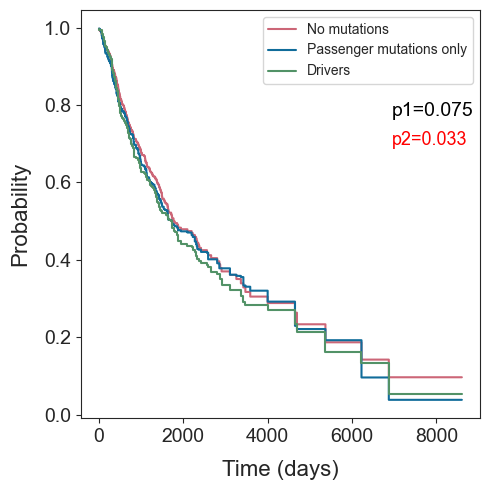

In [14]:
# custom color palette
colors = ["#CC6677", "#106C9A", "#529267", "#eebb44"]
sns.palettes.color_palette(colors)
cmap = sns.color_palette(colors)

tumor_gene_has_driver_data_selected = tumor_gene_driver_data.copy()

# KAPLAN-MEIER PLOTS
plt.figure(figsize=(5, 5))
sns.set_style("ticks")

# samples with no mutations in the gene
kmf_control = KaplanMeierFitter()
group0 = tumor_gene_has_driver_data_selected[tumor_gene_has_driver_data_selected["mutation_status"] == "Has no mutations"]
kmf_control_result = kmf_control.fit(group0["OS.time"], group0["OS"], label='No mutations')
kmf_control_result.plot_survival_function(color=cmap[0], ci_show=False)

# "no mutations" vs "passengers but no drivers"
categories = ["Has passengers with low cadd scores but no drivers", "Has passengers with high cadd scores but no drivers"]
group1 = tumor_gene_has_driver_data_selected[tumor_gene_has_driver_data_selected["mutation_status"].isin(categories)]
if len(group1) > 0:
	kmf_exp1 = KaplanMeierFitter()
	kmf_exp1_result = kmf_exp1.fit(group1["OS.time"], group1["OS"], label='Passenger mutations only')
	kmf_exp1_result.plot_survival_function(color=cmap[1], ci_show=False)
	results1 = logrank_test(group0['OS.time'], group1['OS.time'], event_observed_A=group0['OS'], event_observed_B=group1['OS'])
	p_value1 = results1.p_value
	color1 = 'red' if p_value1 < 0.05 else 'black'
	plt.text(0.78, 0.74, f"p1={p_value1:.3f}", 
		transform=plt.gca().transAxes, fontsize=14, color=color1)

# "no mutations" vs "drivers"
group2 = tumor_gene_has_driver_data_selected[tumor_gene_has_driver_data_selected["mutation_status"] == "Has drivers"]
if len(group2) > 0:
	kmf_exp2 = KaplanMeierFitter()
	kmf_exp2_result = kmf_exp2.fit(group2["OS.time"], group2["OS"], label='Drivers')
	kmf_exp2_result.plot_survival_function(color=cmap[2], ci_show=False)
	results2 = logrank_test(group0['OS.time'], group2['OS.time'], event_observed_A=group0['OS'], event_observed_B=group2['OS'])
	p_value2 = results2.p_value
	color3 = 'red' if p_value2 < 0.05 else 'black'
	plt.text(0.78, 0.67, f"p2={p_value2:.3f}", 
			transform=plt.gca().transAxes, fontsize=13, color=color3)

plt.ylabel('Probability', labelpad=10, fontsize=16)
plt.xlabel('Time (days)', labelpad=10, fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()

## Analysis for Tumor Supressor Genes and Oncogenes

In [15]:
tumor_gene_type_driver_data = tumor_gene_driver_data.copy()
def get_cancer_gene_type(is_oncogene, is_tsg):
    if is_oncogene == "Yes" and is_tsg == "No":
        return "OG"
    elif is_oncogene == "No" and is_tsg == "Yes":
        return "TSG"
    elif is_oncogene == "Yes" and is_tsg == "Yes":
        return "Both"
    else:
        return "Neither"

cancer_gene_type = pd.read_csv(CANCER_GENE_TYPES, sep="\t")
cancer_gene_type["type"] = cancer_gene_type.apply(lambda x: get_cancer_gene_type(x["Is Oncogene"], x["Is Tumor Suppressor Gene"]), axis=1)
cancer_gene_type = cancer_gene_type[["Hugo Symbol", "type"]]
cancer_gene_type.columns = ["gene", "type"]
print(tumor_gene_type_driver_data.shape)
tumor_gene_type_driver_data = pd.merge(tumor_gene_type_driver_data, cancer_gene_type, on="gene", how="left")
print(tumor_gene_type_driver_data.shape)
tumor_gene_type_driver_data.head()

(76680, 6)
(76680, 7)


,Tumor_Sample_Barcode,gene,mutation_status,OS,OS.time,cancer_type,type
0,00493087-9d9d-40ca-86d5-936f1b951c93,CIC,Has drivers,0.0,1201.0,CNS-Oligo,TSG
1,00493087-9d9d-40ca-86d5-936f1b951c93,FUBP1,Has drivers,0.0,1201.0,CNS-Oligo,TSG
2,00493087-9d9d-40ca-86d5-936f1b951c93,IDH1,Has drivers,0.0,1201.0,CNS-Oligo,OG
3,00493087-9d9d-40ca-86d5-936f1b951c93,APC,Has no mutations,0.0,1201.0,CNS-Oligo,TSG
4,00493087-9d9d-40ca-86d5-936f1b951c93,ATM,Has no mutations,0.0,1201.0,CNS-Oligo,TSG


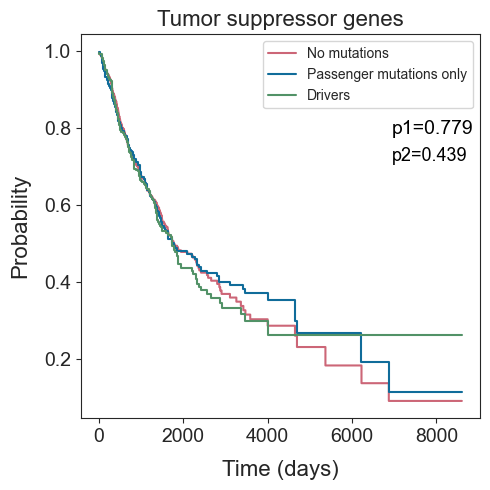

In [16]:
# custom color palette
colors = ["#CC6677", "#106C9A", "#529267", "#eebb44"]
sns.palettes.color_palette(colors)
cmap = sns.color_palette(colors)

tumor_gene_has_driver_data_selected = tumor_gene_type_driver_data[tumor_gene_type_driver_data["type"] == "TSG"]

# KAPLAN-MEIER PLOTS
plt.figure(figsize=(5, 5))
sns.set_style("ticks")

# samples with no mutations in the gene
kmf_control = KaplanMeierFitter()
group0 = tumor_gene_has_driver_data_selected[tumor_gene_has_driver_data_selected["mutation_status"] == "Has no mutations"]
kmf_control_result = kmf_control.fit(group0["OS.time"], group0["OS"], label='No mutations')
kmf_control_result.plot_survival_function(color=cmap[0], ci_show=False)

# "no mutations" vs "passengers but no drivers"
categories = ["Has passengers with low cadd scores but no drivers", "Has passengers with high cadd scores but no drivers"]
group1 = tumor_gene_has_driver_data_selected[tumor_gene_has_driver_data_selected["mutation_status"].isin(categories)]
if len(group1) > 0:
	kmf_exp1 = KaplanMeierFitter()
	kmf_exp1_result = kmf_exp1.fit(group1["OS.time"], group1["OS"], label='Passenger mutations only')
	kmf_exp1_result.plot_survival_function(color=cmap[1], ci_show=False)
	results1 = logrank_test(group0['OS.time'], group1['OS.time'], event_observed_A=group0['OS'], event_observed_B=group1['OS'])
	p_value1 = results1.p_value
	color1 = 'red' if p_value1 < 0.05 else 'black'
	plt.text(0.78, 0.74, f"p1={p_value1:.3f}", 
		transform=plt.gca().transAxes, fontsize=14, color=color1)

# "no mutations" vs "drivers"
group2 = tumor_gene_has_driver_data_selected[tumor_gene_has_driver_data_selected["mutation_status"] == "Has drivers"]
if len(group2) > 0:
	kmf_exp2 = KaplanMeierFitter()
	kmf_exp2_result = kmf_exp2.fit(group2["OS.time"], group2["OS"], label='Drivers')
	kmf_exp2_result.plot_survival_function(color=cmap[2], ci_show=False)
	results2 = logrank_test(group0['OS.time'], group2['OS.time'], event_observed_A=group0['OS'], event_observed_B=group2['OS'])
	p_value2 = results2.p_value
	color3 = 'red' if p_value2 < 0.05 else 'black'
	plt.text(0.78, 0.67, f"p2={p_value2:.3f}", 
			transform=plt.gca().transAxes, fontsize=13, color=color3)

plt.ylabel('Probability', labelpad=10, fontsize=16)
plt.xlabel('Time (days)', labelpad=10, fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("Tumor suppressor genes", fontsize=16)
plt.tight_layout()

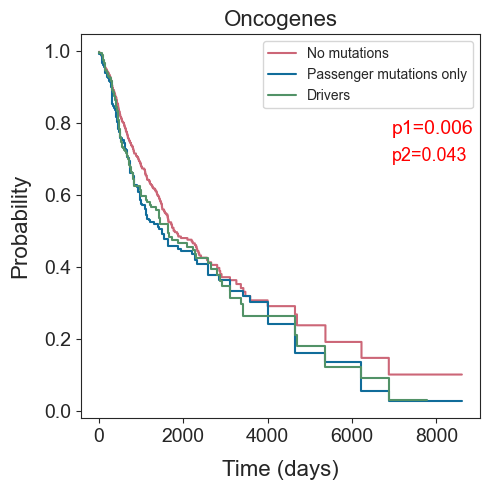

In [17]:
# custom color palette
colors = ["#CC6677", "#106C9A", "#529267", "#eebb44"]
sns.palettes.color_palette(colors)
cmap = sns.color_palette(colors)

tumor_gene_has_driver_data_selected = tumor_gene_type_driver_data[tumor_gene_type_driver_data["type"] == "OG"]

# KAPLAN-MEIER PLOTS
plt.figure(figsize=(5, 5))
sns.set_style("ticks")

# samples with no mutations in the gene
kmf_control = KaplanMeierFitter()
group0 = tumor_gene_has_driver_data_selected[tumor_gene_has_driver_data_selected["mutation_status"] == "Has no mutations"]
kmf_control_result = kmf_control.fit(group0["OS.time"], group0["OS"], label='No mutations')
kmf_control_result.plot_survival_function(color=cmap[0], ci_show=False)

# "no mutations" vs "passengers but no drivers"
categories = ["Has passengers with low cadd scores but no drivers", "Has passengers with high cadd scores but no drivers"]
group1 = tumor_gene_has_driver_data_selected[tumor_gene_has_driver_data_selected["mutation_status"].isin(categories)]
if len(group1) > 0:
	kmf_exp1 = KaplanMeierFitter()
	kmf_exp1_result = kmf_exp1.fit(group1["OS.time"], group1["OS"], label='Passenger mutations only')
	kmf_exp1_result.plot_survival_function(color=cmap[1], ci_show=False)
	results1 = logrank_test(group0['OS.time'], group1['OS.time'], event_observed_A=group0['OS'], event_observed_B=group1['OS'])
	p_value1 = results1.p_value
	color1 = 'red' if p_value1 < 0.05 else 'black'
	plt.text(0.78, 0.74, f"p1={p_value1:.3f}", 
		transform=plt.gca().transAxes, fontsize=14, color=color1)

# "no mutations" vs "drivers"
group2 = tumor_gene_has_driver_data_selected[tumor_gene_has_driver_data_selected["mutation_status"] == "Has drivers"]
if len(group2) > 0:
	kmf_exp2 = KaplanMeierFitter()
	kmf_exp2_result = kmf_exp2.fit(group2["OS.time"], group2["OS"], label='Drivers')
	kmf_exp2_result.plot_survival_function(color=cmap[2], ci_show=False)
	results2 = logrank_test(group0['OS.time'], group2['OS.time'], event_observed_A=group0['OS'], event_observed_B=group2['OS'])
	p_value2 = results2.p_value
	color3 = 'red' if p_value2 < 0.05 else 'black'
	plt.text(0.78, 0.67, f"p2={p_value2:.3f}", 
			transform=plt.gca().transAxes, fontsize=13, color=color3)

plt.ylabel('Probability', labelpad=10, fontsize=16)
plt.xlabel('Time (days)', labelpad=10, fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("Oncogenes", fontsize=16)
plt.tight_layout()

## Gene-level analysis

In [18]:
gene_data = tumor_gene_driver_data.groupby(["gene", "mutation_status"])["Tumor_Sample_Barcode"].nunique().reset_index()
gene_data.rename(columns={"Tumor_Sample_Barcode": "sample_count"}, inplace=True)

# filter for genes with minimum samples in each category
MIN_SAMPLE_COUNT = 10
MIN_DRIVER_COUNT = 5
genes_without_mutations = gene_data[gene_data["mutation_status"] == "Has no mutations"].groupby("gene")["sample_count"].sum().reset_index()
print(genes_without_mutations)
genes_without_mutations = genes_without_mutations[genes_without_mutations["sample_count"] >= MIN_SAMPLE_COUNT]["gene"].tolist()

categories = ["Has passengers with low cadd scores but no drivers", "Has passengers with high cadd scores but no drivers", "Has passengers but no drivers"]
genes_with_only_passengers = gene_data[gene_data["mutation_status"].isin(categories)].groupby("gene")["sample_count"].sum().reset_index()
print(genes_with_only_passengers)
genes_with_only_passengers = genes_with_only_passengers[genes_with_only_passengers["sample_count"] >= MIN_SAMPLE_COUNT]["gene"].tolist()

genes_with_drivers = gene_data[gene_data["mutation_status"] == "Has drivers"].groupby("gene")["sample_count"].sum().reset_index()
print(genes_with_drivers)
genes_with_drivers = genes_with_drivers[genes_with_drivers["sample_count"] >= MIN_DRIVER_COUNT]["gene"].tolist()

genes_of_interest = set(genes_without_mutations) & set(genes_with_only_passengers) & set(genes_with_drivers)
print(len(genes_of_interest), genes_of_interest)

tumor_gene_has_driver_data = tumor_gene_driver_data[tumor_gene_driver_data["gene"].isin(genes_of_interest)]
tumor_analysis_list = tumor_gene_has_driver_data["Tumor_Sample_Barcode"].unique().tolist()
print(f"Number of tumor samples shortlisted for survival analysis: {len(tumor_analysis_list)}")
gene_data.head()

         gene  sample_count
0       AKAP9           692
1       AMER1           696
2         APC           660
3    ARHGAP35           687
4      ARID1A           669
..        ...           ...
103      TP53           420
104     TRRAP           682
105      TSC2           700
106     USP9X           705
107       VHL           693

[108 rows x 2 columns]
         gene  sample_count
0       AKAP9            18
1       AMER1            14
2         APC            22
3    ARHGAP35            18
4      ARID1A            33
..        ...           ...
100      TP53            24
101     TRRAP            24
102      TSC2             9
103     USP9X             5
104       VHL             2

[105 rows x 2 columns]
        gene  sample_count
0        APC            28
1   ARHGAP35             5
2     ARID1A             8
3      ARID2             1
4        ATM            10
..       ...           ...
63  TNFRSF14             2
64      TP53           266
65     TRRAP             4
66      TS

,gene,mutation_status,sample_count
0,AKAP9,Has no mutations,692
1,AKAP9,Has passengers but no drivers,1
2,AKAP9,Has passengers with high cadd scores but no dr...,9
3,AKAP9,Has passengers with low cadd scores but no dri...,8
4,AMER1,Has no mutations,696


FAT1 (640, 6) (60, 6)
SMAD4 (684, 6) (14, 6)
PBRM1 (686, 6) (14, 6)
TP53 (420, 6) (18, 6)
EGFR (660, 6) (30, 6)
BRAF (671, 6) (14, 6)
CDKN2A (679, 6) (11, 6)
TERT (604, 6) (24, 6)
FBXW7 (660, 6) (29, 6)
ATM (674, 6) (25, 6)
RB1 (662, 6) (38, 6)
ARHGAP35 (687, 6) (17, 6)
NOTCH1 (672, 6) (19, 6)
PTEN (671, 6) (23, 6)
CTNNB1 (675, 6) (15, 6)
KMT2D (671, 6) (26, 6)
PIK3CA (562, 6) (53, 6)
KDM6A (695, 6) (9, 6)
ARID1A (669, 6) (30, 6)
CREBBP (677, 6) (21, 6)


/var/folders/1r/lnpzqmmd429dz0fv3s3z1hdh0000gr/T/ipykernel_95011/332279011.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(5, 5))


APC (660, 6) (22, 6)
NFE2L2 (649, 6) (39, 6)


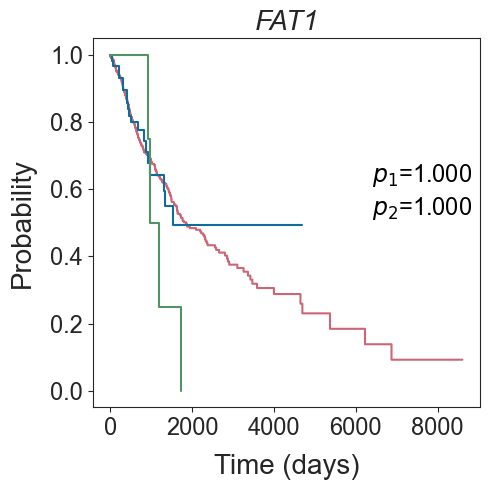

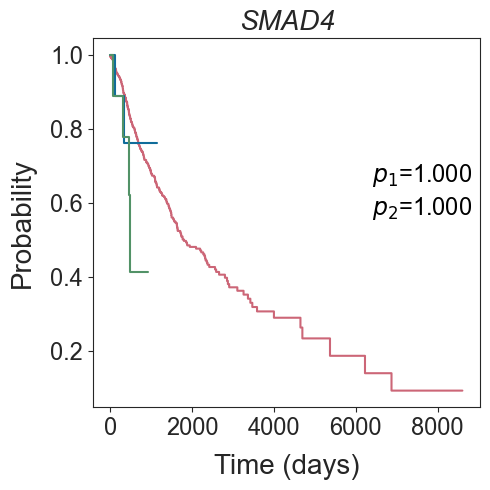

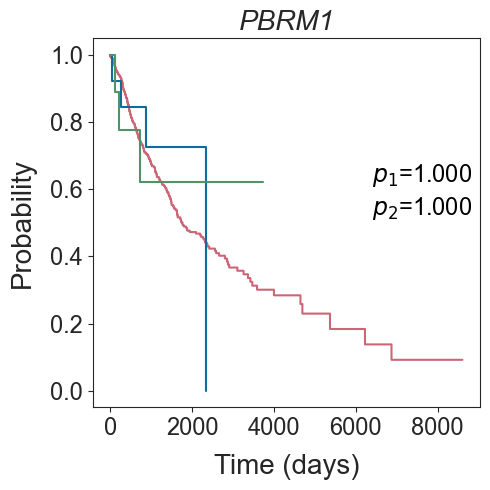

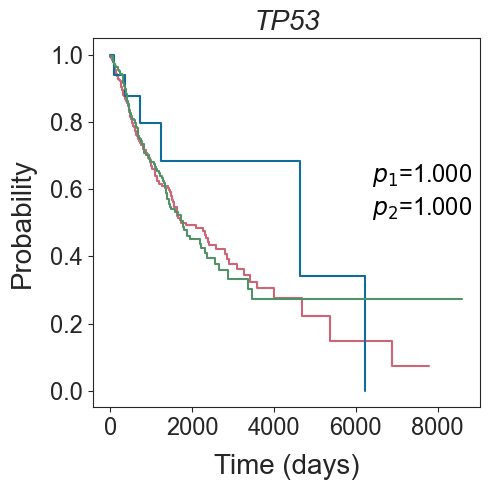

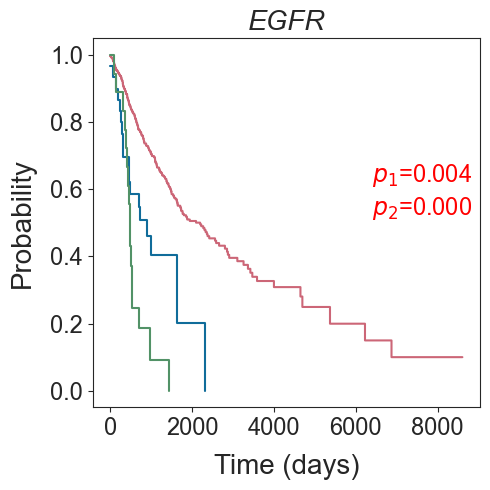

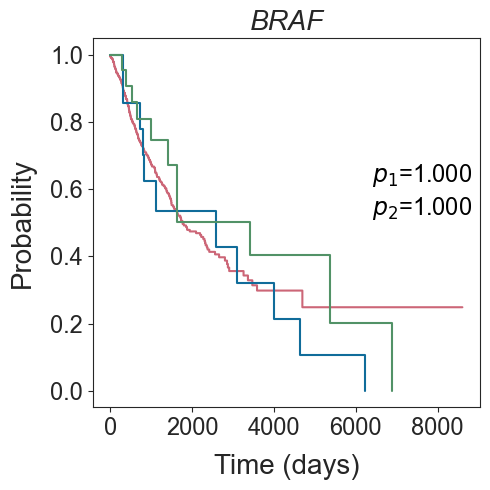

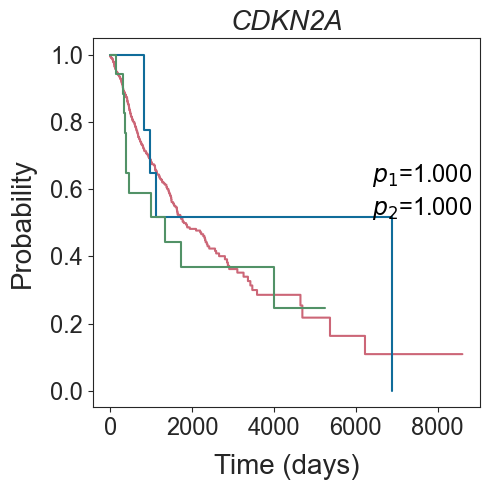

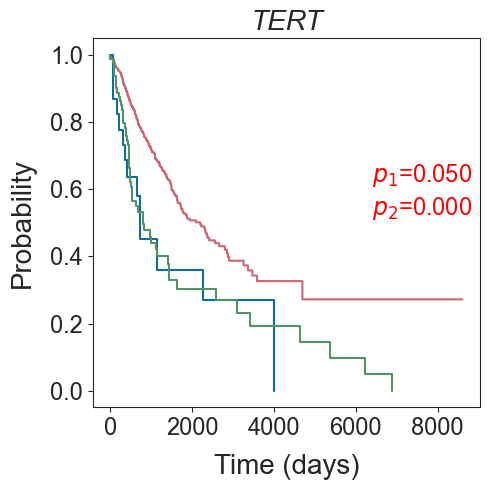

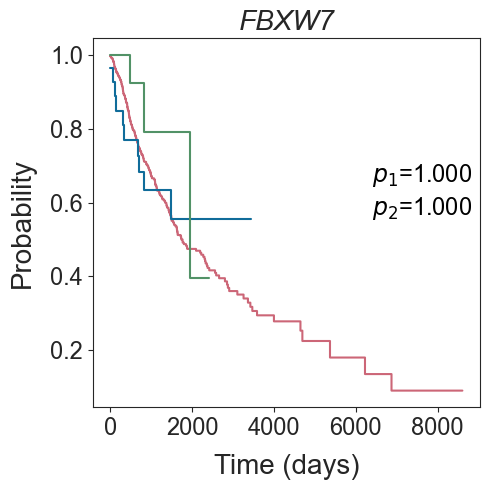

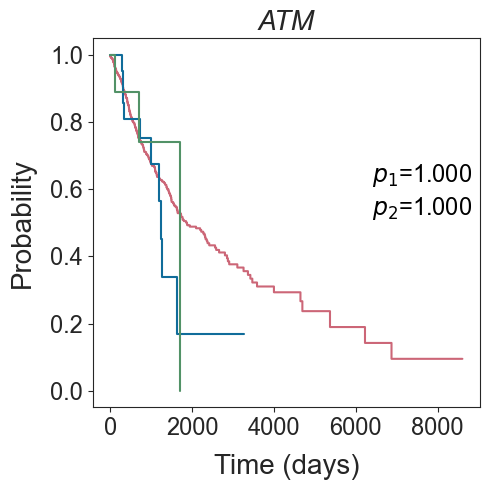

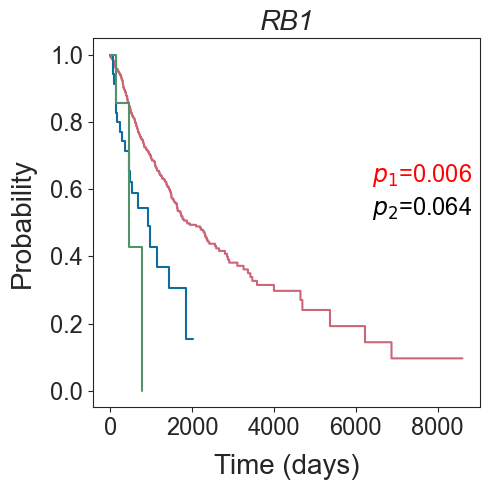

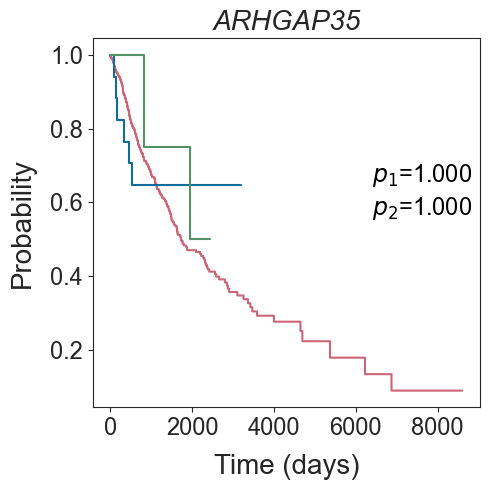

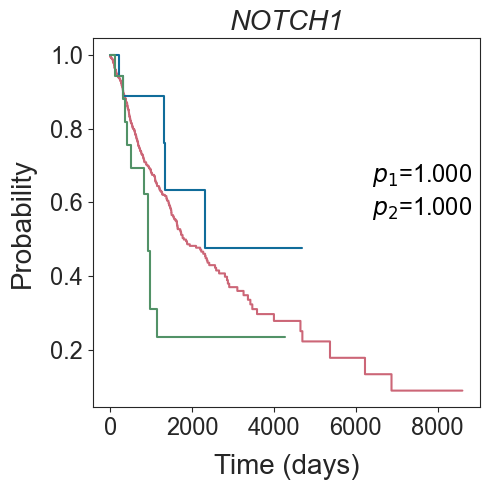

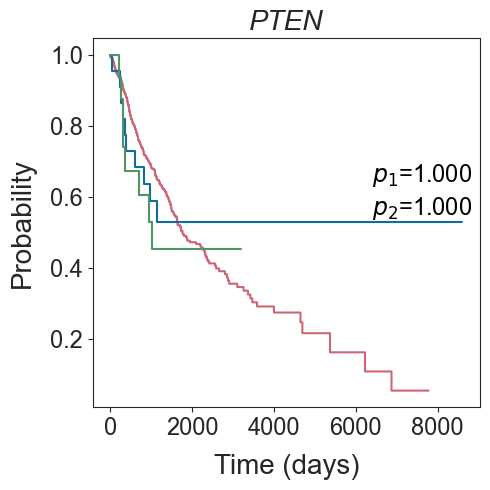

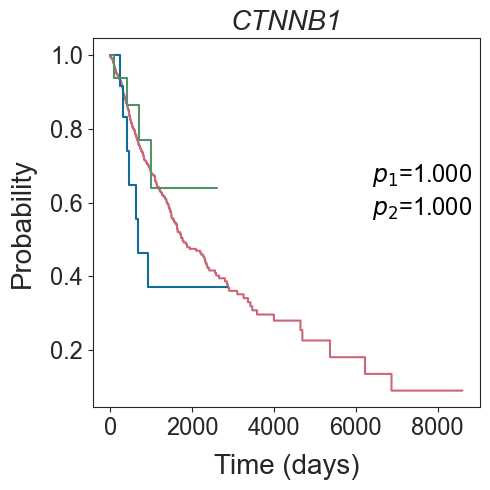

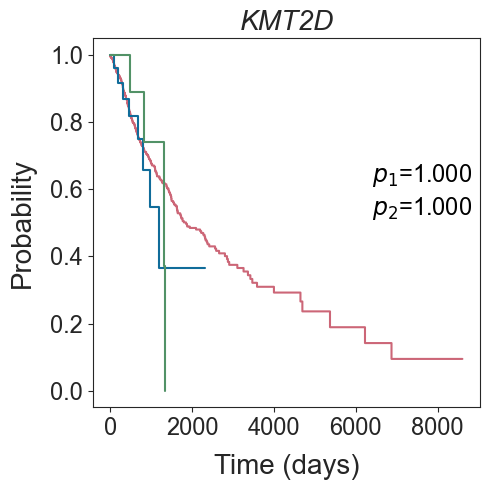

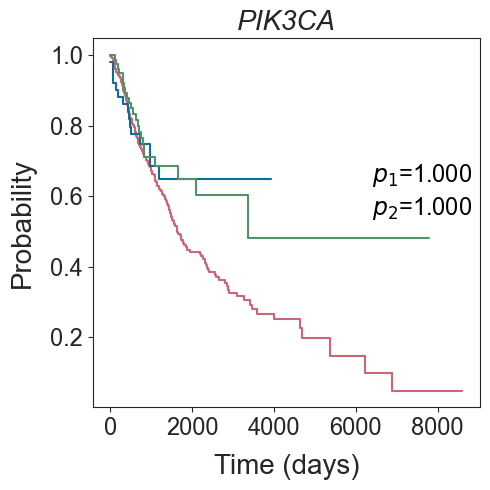

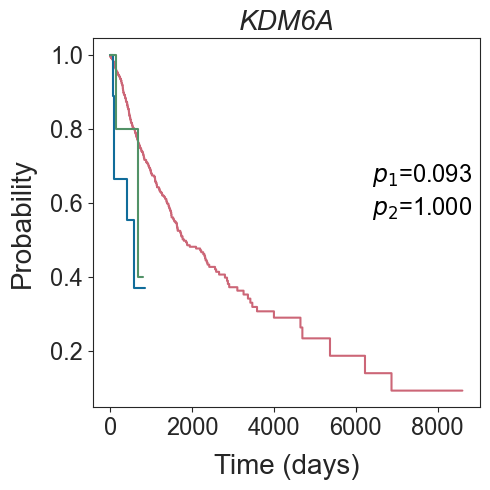

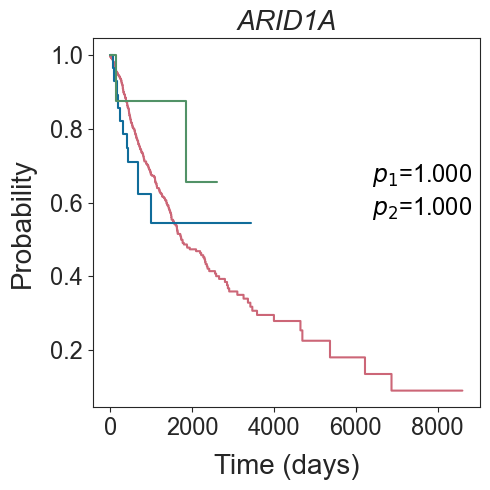

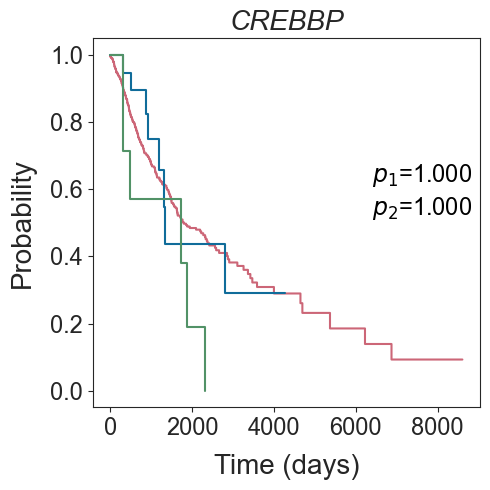

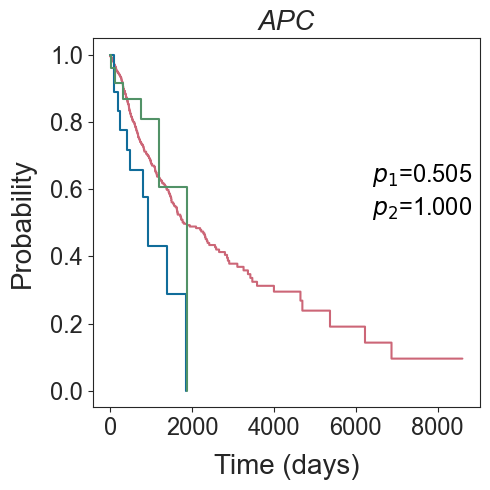

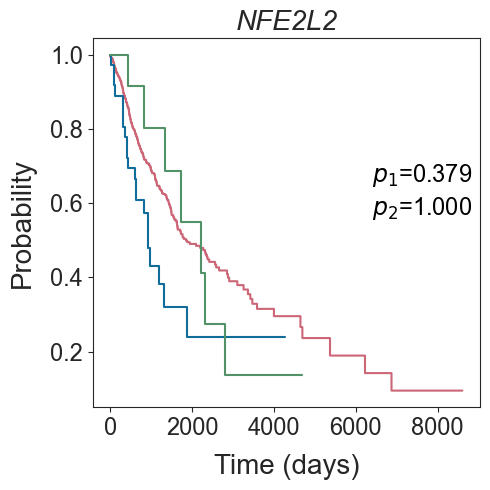

In [19]:
# custom color palette
colors = ["#CC6677", "#106C9A", "#529267", "#eebb44"]
sns.palettes.color_palette(colors)
cmap = sns.color_palette(colors)

# plot Kaplan-Meier survival curves
for gene in genes_of_interest:
	tumor_gene_has_driver_data_selected = tumor_gene_has_driver_data[tumor_gene_has_driver_data["gene"] == gene]

	# KAPLAN-MEIER PLOTS
	plt.figure(figsize=(5, 5))
	sns.set_style("ticks")

	# samples with no mutations in the gene
	kmf_control = KaplanMeierFitter()
	group0 = tumor_gene_has_driver_data_selected[tumor_gene_has_driver_data_selected["mutation_status"] == "Has no mutations"]
	kmf_control_result = kmf_control.fit(group0["OS.time"], group0["OS"], label='No mutations')
	kmf_control_result.plot_survival_function(color=cmap[0], ci_show=False, legend=False)
	
	# "no mutations" vs "passengers but no drivers"
	categories = ["Has passengers with low cadd scores but no drivers", "Has passengers with high cadd scores but no drivers"]
	group1 = tumor_gene_has_driver_data_selected[tumor_gene_has_driver_data_selected["mutation_status"].isin(categories)]
	if len(group1) > 0:
		kmf_exp1 = KaplanMeierFitter()
		kmf_exp1_result = kmf_exp1.fit(group1["OS.time"], group1["OS"], label='Passenger mutations only')
		kmf_exp1_result.plot_survival_function(color=cmap[1], ci_show=False, legend=False)
		results1 = logrank_test(group0['OS.time'], group1['OS.time'], event_observed_A=group0['OS'], event_observed_B=group1['OS'])
		p_value1 = min(results1.p_value * len(genes_of_interest), 1)  # Bonferroni correction for multiple testing
		color1 = 'red' if p_value1 < 0.05 else 'black'
		plt.text(0.72, 0.61, rf"$\it{{p}}_1$={p_value1:.3f}", 
			transform=plt.gca().transAxes, fontsize=17, color=color1)

	# "no mutations" vs "drivers"
	group2 = tumor_gene_has_driver_data_selected[tumor_gene_has_driver_data_selected["mutation_status"] == "Has drivers"]
	if len(group2) > 0:
		kmf_exp2 = KaplanMeierFitter()
		kmf_exp2_result = kmf_exp2.fit(group2["OS.time"], group2["OS"], label='Drivers')
		kmf_exp2_result.plot_survival_function(color=cmap[2], ci_show=False, legend=False)
		results2 = logrank_test(group0['OS.time'], group2['OS.time'], event_observed_A=group0['OS'], event_observed_B=group2['OS'])
		p_value2 = min(results2.p_value * len(genes_of_interest), 1)  # Bonferroni correction for multiple testing
		color3 = 'red' if p_value2 < 0.05 else 'black'
		plt.text(0.72, 0.52, rf"$\it{{p}}_2$={p_value2:.3f}", 
				transform=plt.gca().transAxes, fontsize=17, color=color3)

	plt.ylabel('Probability', labelpad=10, fontsize=20)
	plt.xlabel('Time (days)', labelpad=10, fontsize=20)
	plt.xticks(fontsize=17)
	plt.yticks(fontsize=17)
	plt.title(gene, fontsize=20, fontstyle='italic')
	plt.tight_layout()
	plt.savefig(f"{OS_ANALYSIS}/{gene}_pancan_survival_analysis.png")
	print(gene, group0.shape, group1.shape)

## Gene-level analysis stratified by high and low impact passengers

In [20]:
# filter for genes with minimum samples in each category
MIN_SAMPLE_COUNT = 10
gene_grp0 = gene_data[gene_data["mutation_status"] == "Has no mutations"].groupby("gene")["sample_count"].sum().reset_index()
gene_grp0 = gene_grp0[gene_grp0["sample_count"] >= MIN_SAMPLE_COUNT]["gene"].tolist()

gene_grp1 = gene_data[gene_data["mutation_status"] == "Has passengers with low cadd scores but no drivers"].groupby("gene")["sample_count"].sum().reset_index()
gene_grp1 = gene_grp1[gene_grp1["sample_count"] >= MIN_SAMPLE_COUNT]["gene"].tolist()

gene_grp2 = gene_data[gene_data["mutation_status"] == "Has passengers with high cadd scores but no drivers"].groupby("gene")["sample_count"].sum().reset_index()
gene_grp2 = gene_grp2[gene_grp2["sample_count"] >= MIN_SAMPLE_COUNT]["gene"].tolist()

gene_grp3 = gene_data[gene_data["mutation_status"] == "Has drivers"].groupby("gene")["sample_count"].sum().reset_index()
gene_grp3 = gene_grp3[gene_grp3["sample_count"] >= MIN_DRIVER_COUNT]["gene"].tolist()

genes_of_interest = set(gene_grp0) & set(gene_grp1) & set(gene_grp2) & set(gene_grp3)
print(len(genes_of_interest), genes_of_interest)

3 {'FAT1', 'NFE2L2', 'FBXW7'}


Processing gene: FAT1
(640, 6)
Processing gene: NFE2L2
(649, 6)
Processing gene: FBXW7
(660, 6)


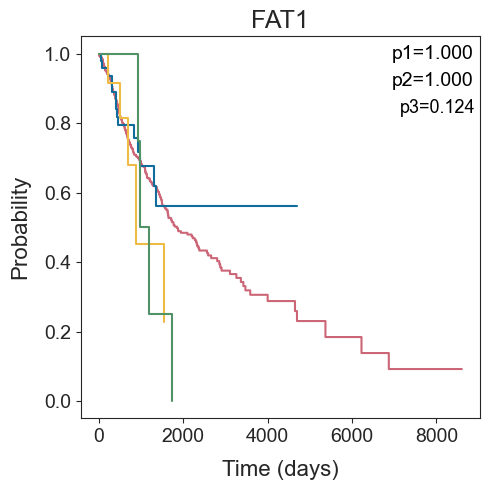

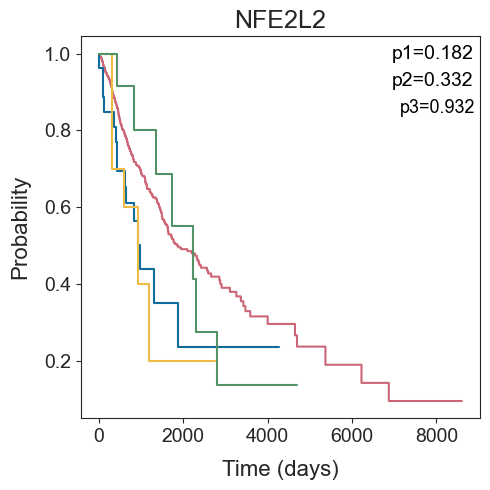

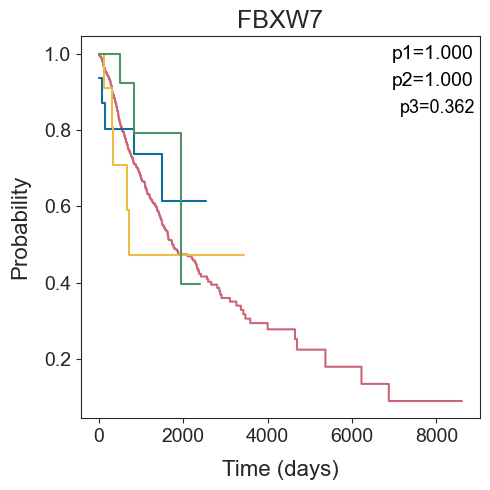

In [21]:
# custom color palette
colors = ["#CC6677", "#106C9A", "#529267", "#eebb44"]
sns.palettes.color_palette(colors)
cmap = sns.color_palette(colors)

# plot Kaplan-Meier survival curves
for gene in genes_of_interest:
	print(f"Processing gene: {gene}")
	tumor_gene_has_driver_data_selected = tumor_gene_driver_data[tumor_gene_driver_data["gene"] == gene]

	# KAPLAN-MEIER PLOTS
	plt.figure(figsize=(5, 5))
	sns.set_style("ticks")

	# samples with no mutations in the gene
	kmf_control = KaplanMeierFitter()
	group0 = tumor_gene_has_driver_data_selected[tumor_gene_has_driver_data_selected["mutation_status"] == "Has no mutations"]
	print(group0.shape)
	kmf_control_result = kmf_control.fit(group0["OS.time"], group0["OS"], label='No mutations')
	kmf_control_result.plot_survival_function(color=cmap[0], ci_show=False, legend=False)
	
	# "no mutations" vs "passengers with low cadd scores but no drivers"
	group1 = tumor_gene_has_driver_data_selected[tumor_gene_has_driver_data_selected["mutation_status"] == "Has passengers with low cadd scores but no drivers"]
	if len(group1) > 0:
		kmf_exp1 = KaplanMeierFitter()
		kmf_exp1_result = kmf_exp1.fit(group1["OS.time"], group1["OS"], label='Low C-score passengers w/o drivers')
		kmf_exp1_result.plot_survival_function(color=cmap[1], ci_show=False, legend=False)
		results1 = logrank_test(group0['OS.time'], group1['OS.time'], event_observed_A=group0['OS'], event_observed_B=group1['OS'])
		p_value1 = min(results1.p_value * len(genes_of_interest), 1)  # Bonferroni correction for multiple testing
		color1 = 'red' if p_value1 < 0.05 else 'black'
		plt.text(0.78, 0.94, f"p1={p_value1:.3f}", 
			transform=plt.gca().transAxes, fontsize=14, color=color1)
	
	# "no mutations" vs "passengers with high cadd scores but no drivers"
	group2 = tumor_gene_has_driver_data_selected[tumor_gene_has_driver_data_selected["mutation_status"] == "Has passengers with high cadd scores but no drivers"]
	if len(group2) > 0:
		kmf_exp2 = KaplanMeierFitter()
		kmf_exp2_result = kmf_exp2.fit(group2["OS.time"], group2["OS"], label='High C-score passengers w/o drivers')
		kmf_exp2_result.plot_survival_function(color=cmap[3], ci_show=False, legend=False)
		results2 = logrank_test(group0['OS.time'], group2['OS.time'], event_observed_A=group0['OS'], event_observed_B=group2['OS'])
		p_value2 = min(results2.p_value * len(genes_of_interest), 1)  # Bonferroni correction for multiple testing
		color2 = 'red' if p_value2 < 0.05 else 'black'
		plt.text(0.78, 0.87, f"p2={p_value2:.3f}", 
			transform=plt.gca().transAxes, fontsize=14, color=color2)

	# "no mutations" vs "drivers"
	group3 = tumor_gene_has_driver_data_selected[tumor_gene_has_driver_data_selected["mutation_status"] == "Has drivers"]
	if len(group3) > 0:
		kmf_exp3 = KaplanMeierFitter()
		kmf_exp3_result = kmf_exp3.fit(group3["OS.time"], group3["OS"], label='Drivers')
		kmf_exp3_result.plot_survival_function(color=cmap[2], ci_show=False, legend=False)
		results3 = logrank_test(group0['OS.time'], group3['OS.time'], event_observed_A=group0['OS'], event_observed_B=group3['OS'])
		p_value3 = results3.p_value
		color3 = 'red' if p_value3 < 0.05 else 'black'
		plt.text(0.8, 0.8, f"p3={p_value3:.3f}", 
				transform=plt.gca().transAxes, fontsize=13, color=color3)

	plt.ylabel('Probability', labelpad=10, fontsize=16)
	plt.xlabel('Time (days)', labelpad=10, fontsize=16)
	plt.xticks(fontsize=14)
	plt.yticks(fontsize=14)
	plt.title(gene, fontsize=18)
	plt.tight_layout()
	plt.savefig(f"{OS_CADD_ANALYSIS}/{gene}_cadd_pancan_analysis.png")

## Pathway-level analysis

In [22]:
all_genes = tumor_survival_data_merged_df["gene"].unique().tolist()
all_genes.sort()
print(f"Number of genes: {len(all_genes)}", all_genes)

gene_pathways = pd.read_csv(CANCER_PATHWAYS)
gene_pathways.dropna(inplace=True)
gene_pathway_map = gene_pathways.set_index("Gene").to_dict()["Pathway"]
print(len(gene_pathway_map), gene_pathway_map)

pathway_genes = {}
for gene, pathway in gene_pathway_map.items():
    if pathway not in pathway_genes:
        pathway_genes[pathway] = []
    pathway_genes[pathway].append(gene)
print(len(pathway_genes), pathway_genes)

gene_pathways.head()

Number of genes: 108 ['AKAP9', 'AMER1', 'APC', 'ARHGAP35', 'ARID1A', 'ARID1B', 'ARID2', 'ATM', 'ATRX', 'AXIN1', 'BCL2', 'BIRC6', 'BRAF', 'BRCA1', 'BRCA2', 'BTG1', 'CARD11', 'CASP8', 'CBFB', 'CCND3', 'CDH1', 'CDH10', 'CDK12', 'CDKN1A', 'CDKN2A', 'CHD4', 'CIC', 'COL1A1', 'CREBBP', 'CSMD3', 'CTNNB1', 'CYP2C8', 'EGFR', 'ELF3', 'EP300', 'ERBB2', 'ERCC2', 'EZH2', 'FAM135B', 'FAT1', 'FAT3', 'FAT4', 'FBXW7', 'FGFR3', 'FGFR4', 'FOXA1', 'FUBP1', 'GATA3', 'GLI1', 'IDH1', 'IL7R', 'KDM5C', 'KDM6A', 'KEAP1', 'KMT2C', 'KMT2D', 'KRAS', 'LATS1', 'LRP1B', 'MAP3K1', 'MCM7', 'MDM2', 'MECOM', 'MED12', 'MET', 'MTOR', 'MYC', 'NACA', 'NBEA', 'NF1', 'NFE2L2', 'NOTCH1', 'NOTCH2', 'NRAS', 'NSD1', 'P2RY8', 'PALB2', 'PBRM1', 'PIK3CA', 'PIK3R1', 'PIM1', 'PPP2R1A', 'PREX2', 'PTEN', 'PTPRD', 'PTPRT', 'RANBP2', 'RB1', 'RBM10', 'RELA', 'RGS7', 'ROBO2', 'SETD2', 'SETDB1', 'SF3B1', 'SGK1', 'SMAD4', 'SOX9', 'SPOP', 'STAG2', 'STK11', 'TERT', 'TNFRSF14', 'TP53', 'TRRAP', 'TSC2', 'USP9X', 'VHL']
136 {'STAG2': 'DNA damage/rep

,Gene,Pathway
0,STAG2,DNA damage/repair
1,CDKN1A,Cell cycle
2,TP53,Cell cycle
3,TP53,DNA damage/repair
4,NSD1,Chromatin remodeling/DNA methylation


In [23]:
tumor_OS_pathway_df = tumor_survival_data_merged_df[["Tumor_Sample_Barcode", "gene", "mutation", "driver", "has_driver", "OS", "OS.time", "num_drivers", "CADD_score_label"]]
tumor_OS_pathway_df["pathway"] = tumor_OS_pathway_df["gene"].apply(lambda x: gene_pathway_map[x] if x in gene_pathway_map else None)
tumor_OS_pathway_df = tumor_OS_pathway_df.dropna(subset=["pathway"])
tumor_has_driver_pathway = tumor_OS_pathway_df.groupby(["Tumor_Sample_Barcode", "pathway"]).agg({
    "has_driver": "any"
}).reset_index()
tumor_OS_pathway_df["has_driver_in_pathway"] = tumor_OS_pathway_df.apply(lambda x: \
    tumor_has_driver_pathway[(tumor_has_driver_pathway["Tumor_Sample_Barcode"] == x["Tumor_Sample_Barcode"]) & \
        (tumor_has_driver_pathway["pathway"] == x["pathway"])]["has_driver"].values[0], axis=1)
tumor_OS_pathway_df["has_driver_in_pathway"] = tumor_OS_pathway_df["has_driver_in_pathway"].apply(lambda x: "Passengers in presence of driver" if x else "Passengers in absence of driver")
tumor_OS_pathway_df["has_driver_in_pathway"] = tumor_OS_pathway_df.apply(lambda x: "Drivers" if x["driver"] == True else x["has_driver_in_pathway"], axis=1)
print(tumor_OS_pathway_df.shape)
tumor_OS_pathway_mut_density = tumor_OS_pathway_df.groupby(["Tumor_Sample_Barcode", "pathway", "has_driver_in_pathway"]).agg({
    "mutation": "count",
    "CADD_score_label": lambda x: list(set(x)),
    "OS": "first",
    "OS.time": "first",
    "num_drivers": "first",
}).reset_index()
tumor_OS_pathway_mut_density["CADD_score_label"] = tumor_OS_pathway_mut_density["CADD_score_label"].apply(lambda x: "high cadd score" if "high cadd score" in x else "low cadd score")
tumor_OS_pathway_mut_density.rename(columns={"mutation": "mutation_count"}, inplace=True)
print(tumor_OS_pathway_mut_density.shape)
tumor_OS_pathway_mut_density = tumor_OS_pathway_mut_density[tumor_OS_pathway_mut_density["has_driver_in_pathway"] != "Passengers in presence of driver"]
print(tumor_OS_pathway_mut_density.shape)
tumor_OS_pathway_mut_density.head()

/var/folders/1r/lnpzqmmd429dz0fv3s3z1hdh0000gr/T/ipykernel_95011/1878899135.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tumor_OS_pathway_df["pathway"] = tumor_OS_pathway_df["gene"].apply(lambda x: gene_pathway_map[x] if x in gene_pathway_map else None)


(26367, 11)
(2757, 8)
(2424, 8)


,Tumor_Sample_Barcode,pathway,has_driver_in_pathway,mutation_count,CADD_score_label,OS,OS.time,num_drivers
0,00493087-9d9d-40ca-86d5-936f1b951c93,Metabolic signaling,Drivers,1,high cadd score,0.0,1201.0,5
1,00aa769d-622c-433e-8a8a-63fb5c41ea42,Beta-Catenin/WNT signaling,Drivers,3,high cadd score,0.0,255.0,18
3,00aa769d-622c-433e-8a8a-63fb5c41ea42,DNA damage/repair,Drivers,1,high cadd score,0.0,255.0,18
5,00aa769d-622c-433e-8a8a-63fb5c41ea42,MAP kinase signaling,Drivers,1,high cadd score,0.0,255.0,18
7,00aa769d-622c-433e-8a8a-63fb5c41ea42,NOTCH signaling,Passengers in absence of driver,11,high cadd score,0.0,255.0,18


In [24]:
tumor_pathway_list = tumor_OS_pathway_mut_density["Tumor_Sample_Barcode"].unique().tolist()
print(f"Number of tumor samples for which we have survival data: {len(tumor_pathway_list)}")

# create a map of mutation counts for each tumor-pathway-has_driver_in_pathway combination
tumor_pathway_has_driver_map = {}
for index, row in tumor_OS_pathway_mut_density.iterrows():
    tumor_pathway_has_driver_map[(row["Tumor_Sample_Barcode"], row["pathway"], row["has_driver_in_pathway"])] = {
        "mutation_count": row["mutation_count"]
    }
print(len(tumor_pathway_has_driver_map), tumor_pathway_has_driver_map)

Number of tumor samples for which we have survival data: 694
2424 {('00493087-9d9d-40ca-86d5-936f1b951c93', 'Metabolic signaling', 'Drivers'): {'mutation_count': 1}, ('00aa769d-622c-433e-8a8a-63fb5c41ea42', 'Beta-Catenin/WNT signaling', 'Drivers'): {'mutation_count': 3}, ('00aa769d-622c-433e-8a8a-63fb5c41ea42', 'DNA damage/repair', 'Drivers'): {'mutation_count': 1}, ('00aa769d-622c-433e-8a8a-63fb5c41ea42', 'MAP kinase signaling', 'Drivers'): {'mutation_count': 1}, ('00aa769d-622c-433e-8a8a-63fb5c41ea42', 'NOTCH signaling', 'Passengers in absence of driver'): {'mutation_count': 11}, ('00aa769d-622c-433e-8a8a-63fb5c41ea42', 'PI3K/AKT1/MTOR', 'Drivers'): {'mutation_count': 2}, ('00aa769d-622c-433e-8a8a-63fb5c41ea42', 'SLIT/ROBO signaling', 'Passengers in absence of driver'): {'mutation_count': 183}, ('00aa769d-622c-433e-8a8a-63fb5c41ea42', 'TGF-Beta signaling', 'Passengers in absence of driver'): {'mutation_count': 3}, ('00bf0350-8c7c-4b9e-8143-13ea2dc1122f', 'Chromatin remodeling/DNA met

In [25]:
tumor_pathway_has_driver_data = []
for tumor in tumor_pathway_list:
    for pathway in pathway_genes.keys():
        if (tumor, pathway, "Drivers") in tumor_pathway_has_driver_map:
            tumor_pathway_has_driver_data.append({
                "Tumor_Sample_Barcode": tumor,
                "pathway": pathway,
                "mutation_status": "Has drivers",
                "OS": tumor_survival_map[tumor]["OS"],
                "OS.time": tumor_survival_map[tumor]["OS.time"]
            })
        elif (tumor, pathway, "Passengers in absence of driver") in tumor_pathway_has_driver_map:
            tumor_pathway_has_driver_data.append({
                "Tumor_Sample_Barcode": tumor,
                "pathway": pathway,
                "mutation_status": "Passengers in absence of driver",
                "OS": tumor_survival_map[tumor]["OS"],
                "OS.time": tumor_survival_map[tumor]["OS.time"]
            })
        else:
            tumor_pathway_has_driver_data.append({
                "Tumor_Sample_Barcode": tumor,
                "pathway": pathway,
                "mutation_status": "Has no mutations",
                "OS": tumor_survival_map[tumor]["OS"],
                "OS.time": tumor_survival_map[tumor]["OS.time"]
            })
tumor_pathway_has_driver_data = pd.DataFrame(tumor_pathway_has_driver_data)
print(tumor_pathway_has_driver_data.shape)
tumor_pathway_has_driver_data.head()

(20820, 5)


,Tumor_Sample_Barcode,pathway,mutation_status,OS,OS.time
0,00493087-9d9d-40ca-86d5-936f1b951c93,DNA damage/repair,Has no mutations,0.0,1201.0
1,00493087-9d9d-40ca-86d5-936f1b951c93,Cell cycle,Has no mutations,0.0,1201.0
2,00493087-9d9d-40ca-86d5-936f1b951c93,Chromatin remodeling/DNA methylation,Has no mutations,0.0,1201.0
3,00493087-9d9d-40ca-86d5-936f1b951c93,Apoptosis,Has no mutations,0.0,1201.0
4,00493087-9d9d-40ca-86d5-936f1b951c93,Gene expression (Transcription),Has no mutations,0.0,1201.0


In [26]:
pathway_data = tumor_pathway_has_driver_data.groupby(["pathway", "mutation_status"])["Tumor_Sample_Barcode"].nunique().reset_index()
pathway_data.rename(columns={"Tumor_Sample_Barcode": "sample_count"}, inplace=True)

# filter for pathways which have samples in all mutation status categories
MIN_SAMPLE_COUNT = 100
MIN_DRIVER_COUNT = 20
pathways_without_mutations = pathway_data[pathway_data["mutation_status"] == "Has no mutations"].groupby("pathway")["sample_count"].sum().reset_index()
pathways_without_mutations = pathways_without_mutations[pathways_without_mutations["sample_count"] >= MIN_SAMPLE_COUNT]["pathway"].tolist()

pathways_with_only_passengers = pathway_data[pathway_data["mutation_status"] == "Passengers in absence of driver"].groupby("pathway")["sample_count"].sum().reset_index()
pathways_with_only_passengers = pathways_with_only_passengers[pathways_with_only_passengers["sample_count"] >= MIN_SAMPLE_COUNT]["pathway"].tolist()

pathways_with_drivers = pathway_data[pathway_data["mutation_status"] == "Has drivers"].groupby("pathway")["sample_count"].sum().reset_index()
pathways_with_drivers = pathways_with_drivers[pathways_with_drivers["sample_count"] >= MIN_DRIVER_COUNT]["pathway"].tolist()

pathways_of_interest = set(pathways_without_mutations) & set(pathways_with_only_passengers) & set(pathways_with_drivers)
print(pathways_of_interest)

# filter for pathways that having atleast 3 genes 
pathways_of_interest_updated = []
for pathway in pathways_of_interest:
    genes_in_pathway = pathway_genes[pathway]
    genes_in_pathway = [gene for gene in genes_in_pathway if gene in all_genes]
    print(pathway, len(genes_in_pathway), genes_in_pathway)
    if len(genes_in_pathway) >= 5:
        pathways_of_interest_updated.append(pathway)
pathways_of_interest = pathways_of_interest_updated
print(len(pathways_of_interest), pathways_of_interest)
pathway_data = pathway_data[pathway_data["pathway"].isin(pathways_of_interest)]

tumor_pathway_has_driver_data = tumor_pathway_has_driver_data[tumor_pathway_has_driver_data["pathway"].isin(pathways_of_interest)]
tumor_pathway_analysis_list = tumor_pathway_has_driver_data["Tumor_Sample_Barcode"].unique().tolist()
print(f"Number of tumor samples shortlisted for survival analysis: {len(tumor_pathway_analysis_list)}")
# pathway_data.head()

{'PI3K/AKT1/MTOR', 'Chromatin remodeling/DNA methylation', 'NOTCH signaling'}
PI3K/AKT1/MTOR 11 ['TNFRSF14', 'FOXA1', 'SGK1', 'PREX2', 'PIK3R1', 'TSC2', 'STK11', 'MECOM', 'PTEN', 'MTOR', 'PIK3CA']
Chromatin remodeling/DNA methylation 12 ['NSD1', 'ARID1B', 'ARID1A', 'SETD2', 'KDM6A', 'EZH2', 'PBRM1', 'KDM5C', 'KMT2D', 'ARID2', 'SETDB1', 'KMT2C']
NOTCH signaling 7 ['NOTCH1', 'CREBBP', 'ELF3', 'NBEA', 'NOTCH2', 'EP300', 'FBXW7']
3 ['PI3K/AKT1/MTOR', 'Chromatin remodeling/DNA methylation', 'NOTCH signaling']
Number of tumor samples shortlisted for survival analysis: 694


In [27]:
# # calculate p-values for logrank test for each pathway
# pathway_p1_values = {}
# pathway_p2_values = {}
# for pathway in pathways_of_interest:
# 	tumor_pathway_has_driver_data_selected = tumor_pathway_has_driver_data[tumor_pathway_has_driver_data["pathway"] == pathway]
# 	group0 = tumor_pathway_has_driver_data_selected[tumor_pathway_has_driver_data_selected["mutation_status"] == "Has no mutations"]
# 	group1 = tumor_pathway_has_driver_data_selected[tumor_pathway_has_driver_data_selected["mutation_status"] == "Passengers in absence of driver"]
# 	group2 = tumor_pathway_has_driver_data_selected[tumor_pathway_has_driver_data_selected["mutation_status"] == "Has drivers"]

# 	results1 = logrank_test(group0['OS.time'], group1['OS.time'], event_observed_A=group0['OS'], event_observed_B=group1['OS'])
# 	results2 = logrank_test(group0['OS.time'], group2['OS.time'], event_observed_A=group0['OS'], event_observed_B=group2['OS'])
# 	pathway_p1_values[pathway] = results1.p_value
# 	pathway_p2_values[pathway] = results2.p_value
# print(len(pathway_p1_values), pathway_p1_values)
# print(len(pathway_p2_values), pathway_p2_values)
# pvals1 = list(pathway_p1_values.values())
# pvals2 = list(pathway_p2_values.values())
# print(statsmodels.stats.multitest.multipletests(pvals1, alpha=0.05, method='sidak', is_sorted=False, returnsorted=False))
# print(statsmodels.stats.multitest.multipletests(pvals2, alpha=0.05, method='sidak', is_sorted=False, returnsorted=False))

PI3K/AKT1/MTOR ['TNFRSF14', 'FOXA1', 'SGK1', 'PREX2', 'PIK3R1', 'TSC2', 'STK11', 'MECOM', 'PTEN', 'MTOR', 'PIK3CA']


Chromatin remodeling/DNA methylation ['NSD1', 'ARID1B', 'ARID1A', 'SETD2', 'KDM6A', 'EZH2', 'PBRM1', 'KDM5C', 'KMT2D', 'ARID2', 'SETDB1', 'KMT2C']
NOTCH signaling ['NOTCH1', 'CREBBP', 'ELF3', 'NBEA', 'NOTCH2', 'EP300', 'FBXW7']


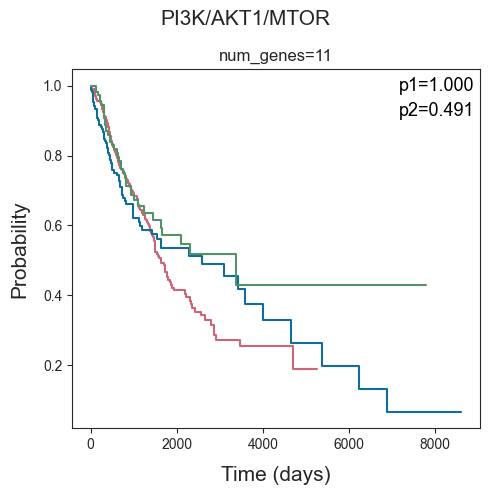

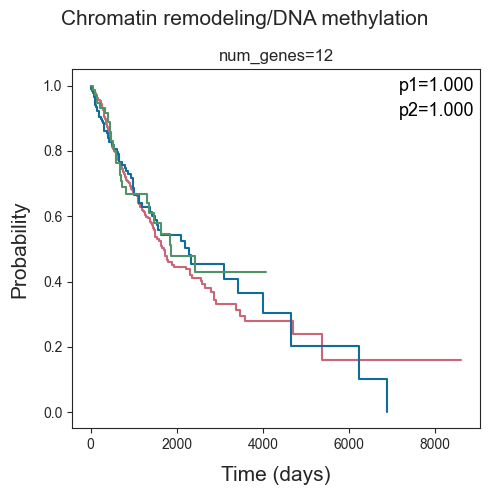

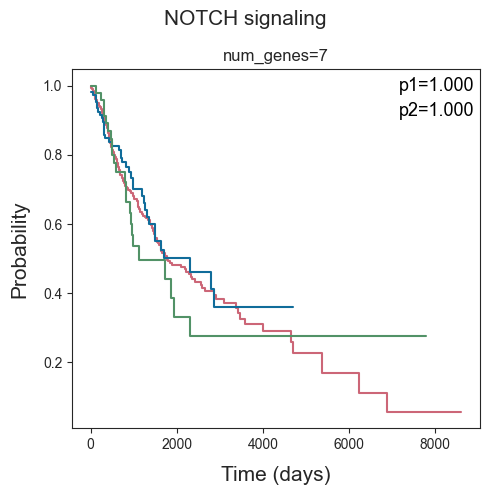

In [28]:
# plot Kaplan-Meier survival curves
for pathway in pathways_of_interest:
	genes_in_pathway = pathway_genes[pathway]
	genes_in_pathway = [gene for gene in genes_in_pathway if gene in all_genes]
	print(pathway, genes_in_pathway)
	tumor_pathway_has_driver_data_selected = tumor_pathway_has_driver_data[tumor_pathway_has_driver_data["pathway"] == pathway]

	# KAPLAN-MEIER PLOTS
	plt.figure(figsize=(5, 5))
	sns.set_style("ticks")

	# samples with no mutations in the pathway
	kmf_control = KaplanMeierFitter()
	group0 = tumor_pathway_has_driver_data_selected[tumor_pathway_has_driver_data_selected["mutation_status"] == "Has no mutations"]
	kmf_control_result = kmf_control.fit(group0["OS.time"], group0["OS"], label='No mutations')
	kmf_control_result.plot_survival_function(color=cmap[0], ci_show=False, legend=False)

	# samples with only passenger mutations in the pathway
	kmf_exp1 = KaplanMeierFitter()
	group1 = tumor_pathway_has_driver_data_selected[tumor_pathway_has_driver_data_selected["mutation_status"] == "Passengers in absence of driver"]
	if len(group1) > 0:
		kmf_exp1_result = kmf_exp1.fit(group1["OS.time"], group1["OS"], label='Passenger mutations only')
		kmf_exp1_result.plot_survival_function(color=cmap[1], ci_show=False, legend=False)
		results1 = logrank_test(group0['OS.time'], group1['OS.time'], event_observed_A=group0['OS'], event_observed_B=group1['OS'])
		p_value1 = min(results1.p_value * len(pathways_of_interest), 1)  # Bonferroni correction for multiple testing
		color1 = 'red' if p_value1 < 0.05 else 'black'
		plt.text(0.8, 0.94, f"p1={p_value1:.3f}",
				transform=plt.gca().transAxes, fontsize=13, color=color1)

	# samples with driver mutations in the pathway
	kmf_exp2 = KaplanMeierFitter()
	group2 = tumor_pathway_has_driver_data_selected[tumor_pathway_has_driver_data_selected["mutation_status"] == "Has drivers"]
	if len(group2) > 0:
		kmf_exp2_result = kmf_exp2.fit(group2["OS.time"], group2["OS"], label='Drivers')
		kmf_exp2_result.plot_survival_function(color=cmap[2], ci_show=False, legend=False)
		results2 = logrank_test(group0['OS.time'], group2['OS.time'], event_observed_A=group0['OS'], event_observed_B=group2['OS'])
		p_value2 = min(results2.p_value * len(pathways_of_interest), 1) # Bonferroni correction for multiple testing
		color2 = 'red' if p_value2 < 0.05 else 'black'
		plt.text(0.8, 0.87, f"p2={p_value2:.3f}",
				transform=plt.gca().transAxes, fontsize=13, color=color2)

	plt.ylabel('Probability', labelpad=10, fontsize=15)
	plt.xlabel('Time (days)', labelpad=10, fontsize=15)
	plt.suptitle(f"{pathway}", fontsize=15)
	plt.title(f"num_genes={len(genes_in_pathway)}", fontsize=12)
	plt.tight_layout()
	plt.savefig(f"{OS_ANALYSIS_PATHWAY}/pancancer_OS_analysis.png")